In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/ASSS 3/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


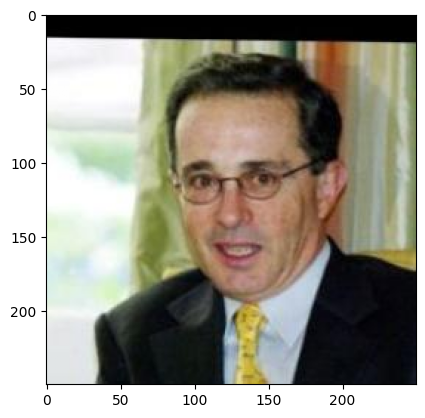

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [7]:
# Step 2: Get a sample from the dataloader and print its dimensions

# Get a single batch from the dataloader
sample_batch, sample_labels = next(iter(dataloader))

# Display the dimensions of the sample
print(f"Sample Dimensions: {sample_batch.shape}")

# Explain each dimension
batch_size, channels, height, width = sample_batch.shape
print(f"Batch Size: {batch_size}")
print(f"Number of Channels: {channels}")
print(f"Image Height: {height}")
print(f"Image Width: {width}")


Sample Dimensions: torch.Size([32, 3, 250, 250])
Batch Size: 32
Number of Channels: 3
Image Height: 250
Image Width: 250


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

 def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(128)

        # Additional encoder layer
        self.encoder_conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.encoder_bn4 = nn.BatchNorm2d(256)

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(128)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(64)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn3 = nn.BatchNorm2d(32)

        # Additional decoder layers
        self.decoder_conv4 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = F.relu(self.encoder_bn3(self.encoder_conv3(x)))
        x = F.relu(self.encoder_bn4(self.encoder_conv4(x)))
        return x

    def decoder(self, x):
        # Adjust the ConvTranspose2d layer to compensate for the reduction in encoder
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))
        x = F.relu(self.decoder_bn2(self.decoder_conv2(x)))
        x = F.relu(self.decoder_bn3(self.decoder_conv3(x)))
        x = torch.sigmoid(self.decoder_conv4(x))
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Upsample to match input size
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Create an instance of the AE model
autoencoder = AE()

# Print total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")



Total Number of Parameters: 187017


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [9]:
import torch
import torch.nn.functional as F

# Get a sample from the dataloader
for x, y in dataloader:
    sample_image = x[0]  # Take the first image from the batch as a sample
    break

# Reshape the sample image to include a batch dimension
sample_image = sample_image.unsqueeze(0)

# Ensure the autoencoder model is on the MPS device and convert the sample image
sample_image = sample_image.to(dtype=torch.float32)

# Pass the sample image through the autoencoder
with torch.no_grad():
    encoded_output = autoencoder.encoder(sample_image)
    decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print(f"Shape of Encoder Output: {encoded_output.shape}")
print(f"Shape of Decoder Output: {decoded_output.shape}")


Shape of Encoder Output: torch.Size([1, 128, 32, 32])
Shape of Decoder Output: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [10]:
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")


Total Number of Parameters: 187017


In [11]:
import torch.optim as optim

# Create an instance of the AE model
autoencoder = AE()

# Print total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.001  # Adjust as needed
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


Total Number of Parameters: 187017


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

**Verify Data Quality**--->Confirm that my training data is varied and representative.

**Modify Learning Rate**--->Test different learning rates to find the optimal balance.

**Augment Data**---> If feasible, boost the volume of training data.

**Adjust Model Architecture**---> Experiment with alternative model types or complexity adjustments.

**Extend Training Duration**---> Allow the model more epochs to enhance learning.

**Debug** **Code**---> Examine my code for errors or bugs.

**Assess Task Complexity**---> Reevaluate if the task is realistically attainable with the available data and model.

In [12]:
num_epochs = 9  # You can adjust this value

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    print(f'Epoch [{epoch+1}/{num_epochs}]:', end=' ')

    for batch_idx, (inputs, _) in enumerate(dataloader):
        # Move inputs to the MPS device if needed
        inputs = inputs.to(dtype=torch.float32)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)

        # Ensure the output size matches the input size
        outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bilinear', align_corners=False)

        # Calculate the loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print a simple progress bar
        print('█', end='', flush=True)

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'\nAverage Loss: {average_loss:.4f}')

# Training complete
print('Finished Training')


Epoch [1/9]: ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
Average Loss: 0.0178
Epoch [2/9]: ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
Average Loss: 0.0069
Epoch [3/9]: █████████████████████████████████████████████████████████████████████████████████████████

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Original Image:


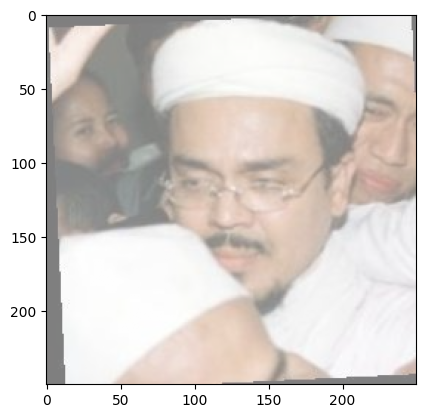

Reconstructed Image:


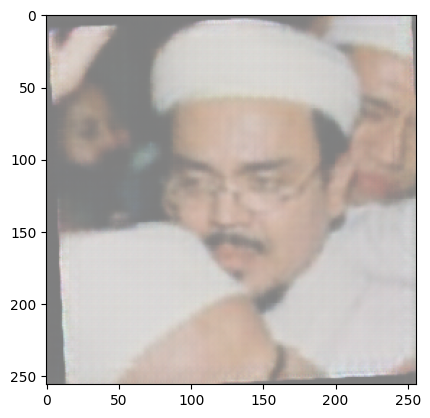

In [14]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a random batch of images from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0].unsqueeze(0)

# Pass the random image through the autoencoder
reconstructed_image = autoencoder(random_image)

# Display the original and reconstructed images using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Display the original image
axs[0].set_title("Original Image")
axs[0].imshow(np.transpose(random_image.squeeze().numpy(), (1, 2, 0)))
axs[0].axis('off')

# Display the reconstructed image
axs[1].set_title("Reconstructed Image")
axs[1].imshow(np.transpose(reconstructed_image.squeeze().detach().numpy(), (1, 2, 0)))
axs[1].axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

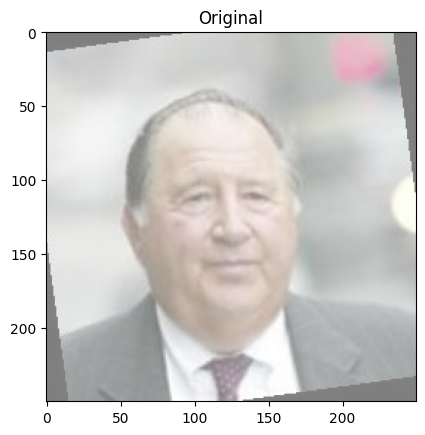

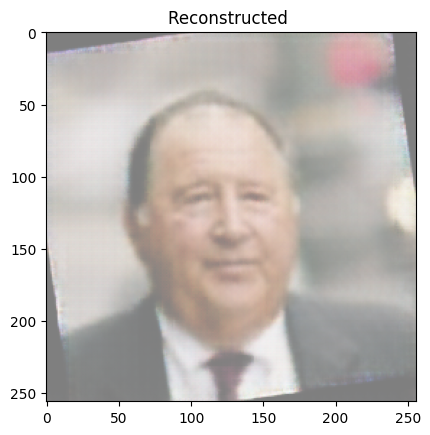

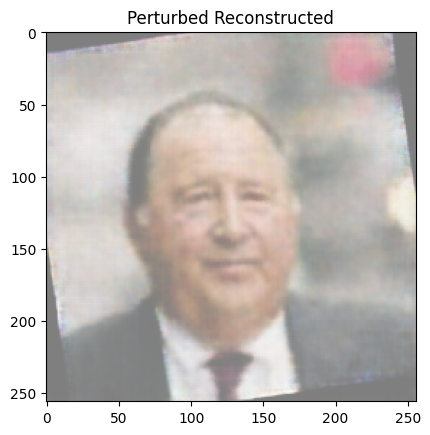

In [30]:
# Load the dataset and create the dataloader
path = 'lfw'
transform = transforms.Compose([transforms.Resize((250, 250)), transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Function to add noise to the latent representation
def add_noise(latent_representation, noise_factor=0.2):
    noise = torch.randn_like(latent_representation) * noise_factor
    perturbed_latent = latent_representation + noise
    return perturbed_latent

# Get a random image from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0].unsqueeze(0)


# Pass the random image through the autoencoder
encoded_output = autoencoder.encoder(random_image)
decoded_output = autoencoder.decoder(encoded_output)

# Display the original and reconstructed images
imshow(torchvision.utils.make_grid(random_image), title="Original")
imshow(torchvision.utils.make_grid(decoded_output), title="Reconstructed ")

# Add noise to the latent representation
perturbed_latent = add_noise(encoded_output)
perturbed_decoded_output = autoencoder.decoder(perturbed_latent)
imshow(torchvision.utils.make_grid(perturbed_decoded_output), title="Perturbed Reconstructed")

**Improve the Robustness**---> Enhances the model's capability to handle noisy real-world data.

**Serves as Regularization**---> Prevents overfitting by introducing noise, encouraging improved generalization.

**Increese Denoising**---> Trains the model to eliminate added noise, particularly beneficial for tasks such as image denoising.

**Improve Tolerance**---> Reduces the model's sensitivity to minor input variations, improving performance across diverse scenarios.